In [1]:
#Importing Libraries

from keras.preprocessing.image import ImageDataGenerator
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow.keras.utils import img_to_array, array_to_img,load_img

2022-09-10 17:18:21.561296: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-10 17:18:21.561414: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [8]:
# Getting Images

train_dataset = 'Dataset/images/train'
X = []
for imagename in os.listdir(train_dataset):
    X.append(img_to_array(load_img(train_dataset + "/" +imagename, target_size=(256, 256))))

X = np.array(X, dtype=float)

#Set up train and test data

split = int(0.95 * len(X))
Xtrain = X[:split]
#normalizing the color in the range [0-1]
Xtrain = 1.0/255* Xtrain

In [10]:
#CNN model 
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras import Sequential

In [11]:
model = Sequential()

#Input Layer
model.add(Conv2D(64, (3, 3), input_shape=(256, 256, 1), activation='relu', padding='same'))

#Hidden Layers
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

#Compiling the CNN
model.compile(optimizer='rmsprop', loss='mse', metrics = ['accuracy'])

Epoch 1/5


2022-09-10 17:58:50.216973: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 167772160 exceeds 10% of free system memory.
2022-09-10 17:58:50.434851: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 41943040 exceeds 10% of free system memory.
2022-09-10 17:58:50.550406: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 83886080 exceeds 10% of free system memory.
2022-09-10 17:58:50.876938: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 41943040 exceeds 10% of free system memory.
2022-09-10 17:58:51.539461: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 41943040 exceeds 10% of free system memory.


30/30 [==============================] - 158s 5s/step - loss: 0.8893 - accuracy: 0.7406
Epoch 2/5
30/30 [==============================] - 157s 5s/step - loss: 0.9142 - accuracy: 0.7824
Epoch 3/5
30/30 [==============================] - 184s 6s/step - loss: 0.6078 - accuracy: 0.7856
Epoch 4/5
30/30 [==============================] - 206s 7s/step - loss: 0.0142 - accuracy: 0.7891
Epoch 5/5
30/30 [==============================] - 187s 6s/step - loss: 0.0140 - accuracy: 0.7835


INFO:tensorflow:Assets written to: my_model/output_model/assets


INFO:tensorflow:Assets written to: my_model/output_model/assets


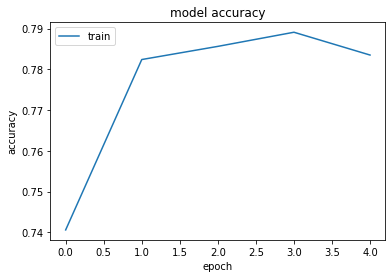

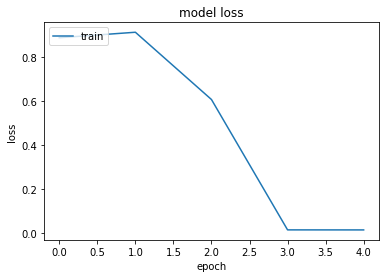

In [13]:
import matplotlib.pyplot as plt

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

# Generate training data
batch_size = 10
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

# Train model      
tensorboard = TensorBoard(log_dir="./output/beta_run")
trainedmodel = model.fit(image_a_b_gen(batch_size), callbacks=[tensorboard],epochs=5, steps_per_epoch=30)

# Saving the model
model.save('my_model/output_model')


# summarize history for accuracy
plt.plot(trainedmodel.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(trainedmodel.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [6]:
# Load black and white images
import keras
# load the model
model = keras.models.load_model('./model.h5')

ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x7fbbac043ee0>.

In [ ]:
# Load black and white images
color_me = []
for filename in os.listdir('./Test/'):
  color_me.append(img_to_array(load_img('./Test/'+filename)))
color_me = np.array(color_me, dtype=float)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))
# Test model
output = model.predict(color_me)
output = output * 128
# Output colorizations
for i in range(len(output)):
  cur = np.zeros((256, 256, 3))
  cur[:,:,0] = color_me[i][:,:,0]
  cur[:,:,1:] = output[i]
  imsave("./result/img_"+str(i)+".png", lab2rgb(cur))